In [1]:
# Add parent directory to path so that we can import modules from the parent directory
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from llm import LLMGoalGenerator, ConstantLLM
from utils import TextEmbedder, visualize_obs
from ellm_reward import ELLMRewardCalculator
from train import (SharedState,
                make_full_train_env)
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack
import yaml

/home/grotehans/miniconda3/envs/text-crafter-latest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../configs/ConstantGoalGenerator/run_seed-1_ConstantGoalGenerator_novelty-bias_reward-on-ac-success.yaml', "r") as yamlfile:
    env_spec = yaml.load(yamlfile, Loader=yaml.FullLoader)

In [3]:
language_model = ConstantLLM(response="- don't eat animals") # for debugging other parts that do not need GPU, if you use this you don't need to submit a job to the cluster
goal_generator = LLMGoalGenerator(language_model=language_model)
obs_embedder = TextEmbedder()
reward_calculator = ELLMRewardCalculator()

# Some things need to be shared between wrappers, so we use a shared state object
shared_state = SharedState()

/home/grotehans/miniconda3/envs/text-crafter-latest/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [7]:
train_env = make_vec_env(make_full_train_env, 
                             n_envs=1, 
                             seed=env_spec['seed'], 
                             env_kwargs={'env_spec': env_spec,
                                         'reward_calculator': reward_calculator, 
                                         'goal_generator': goal_generator, 
                                         'obs_embedder': obs_embedder, 
                                         'shared_state': shared_state, 
                                         'device': 'cpu',
                                         })
train_env = VecFrameStack(train_env, n_stack=env_spec['frame_stack'])

In [8]:
obs, info = train_env.reset()

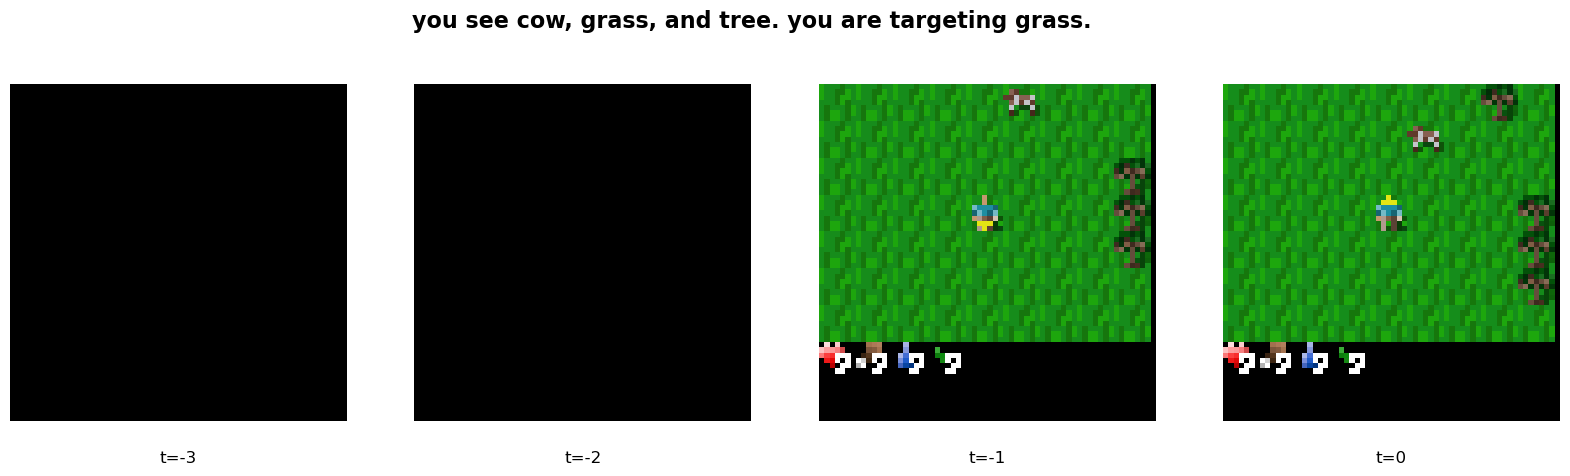

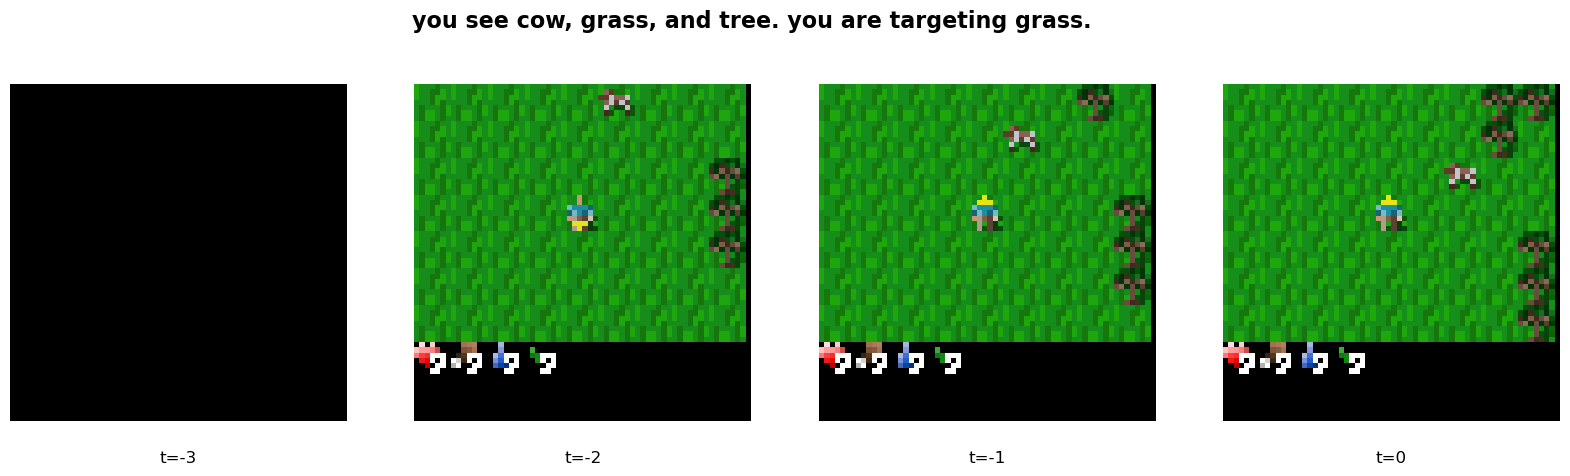

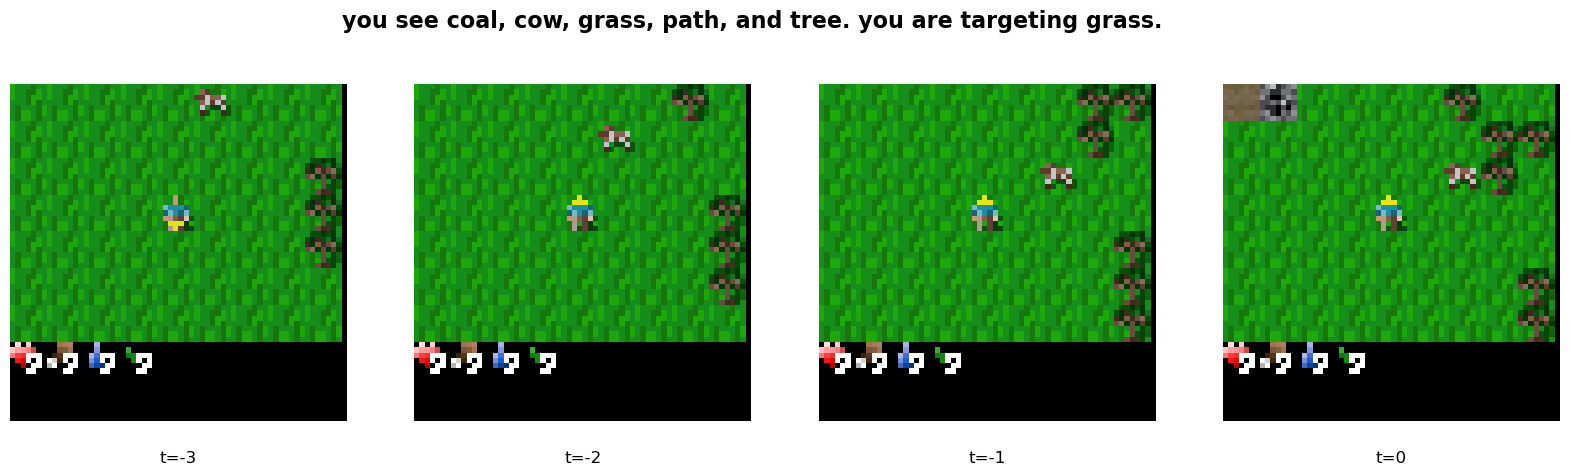

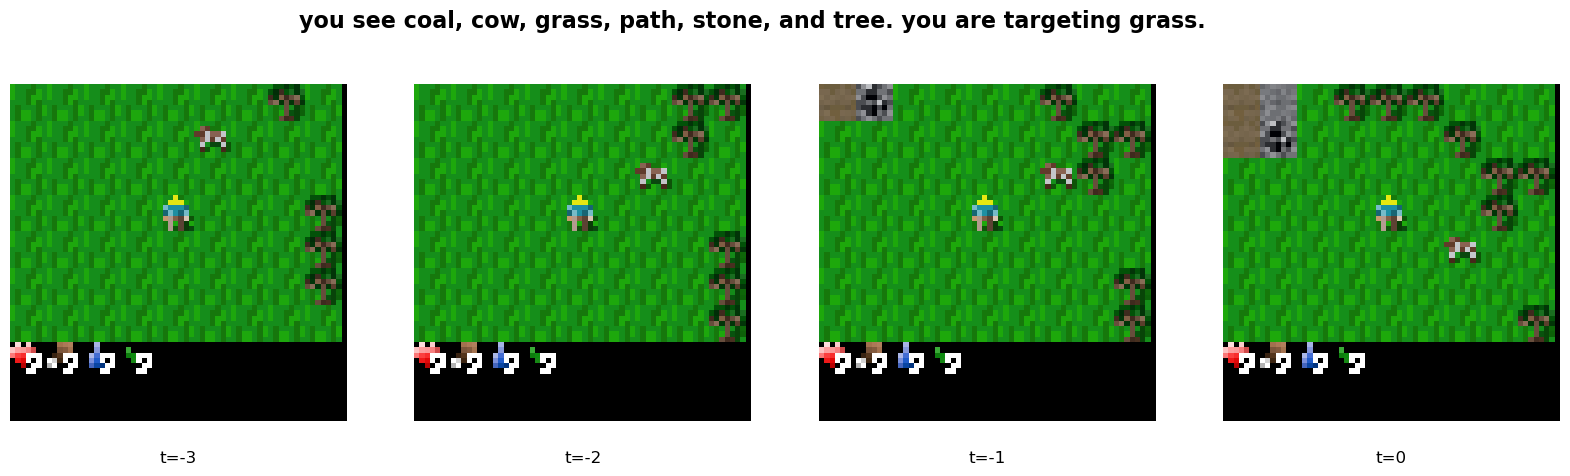

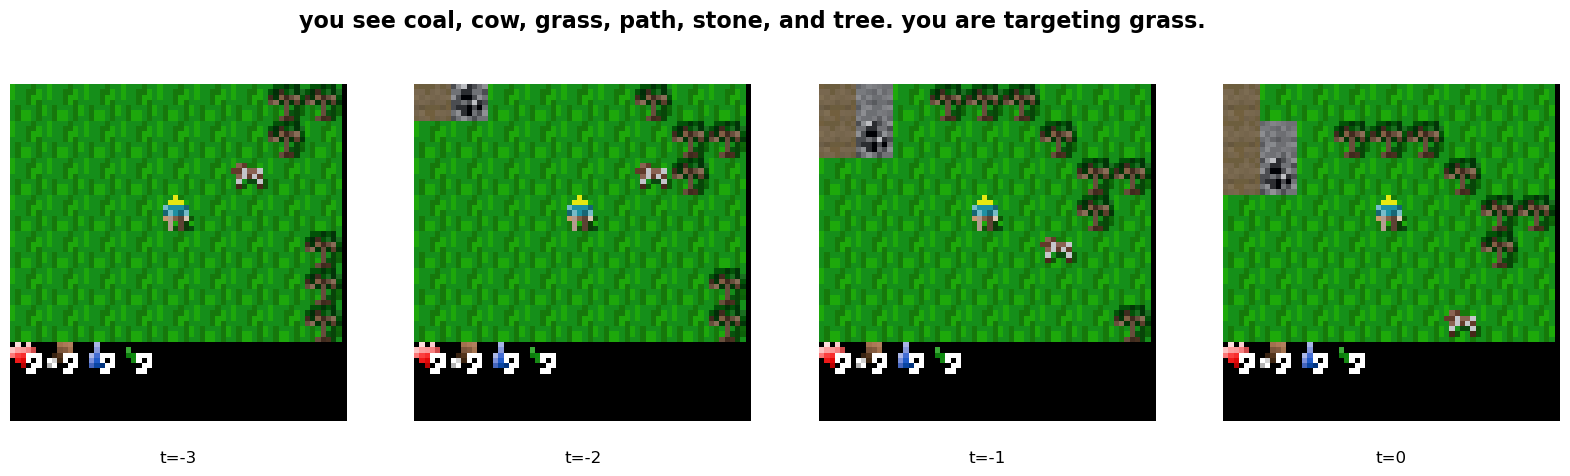

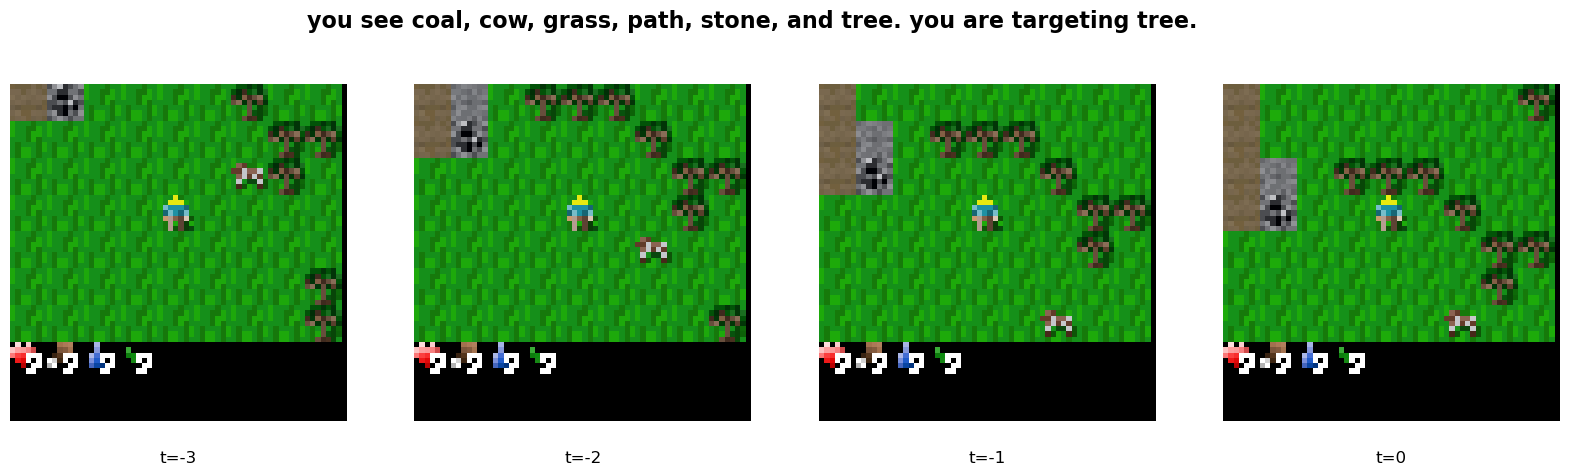

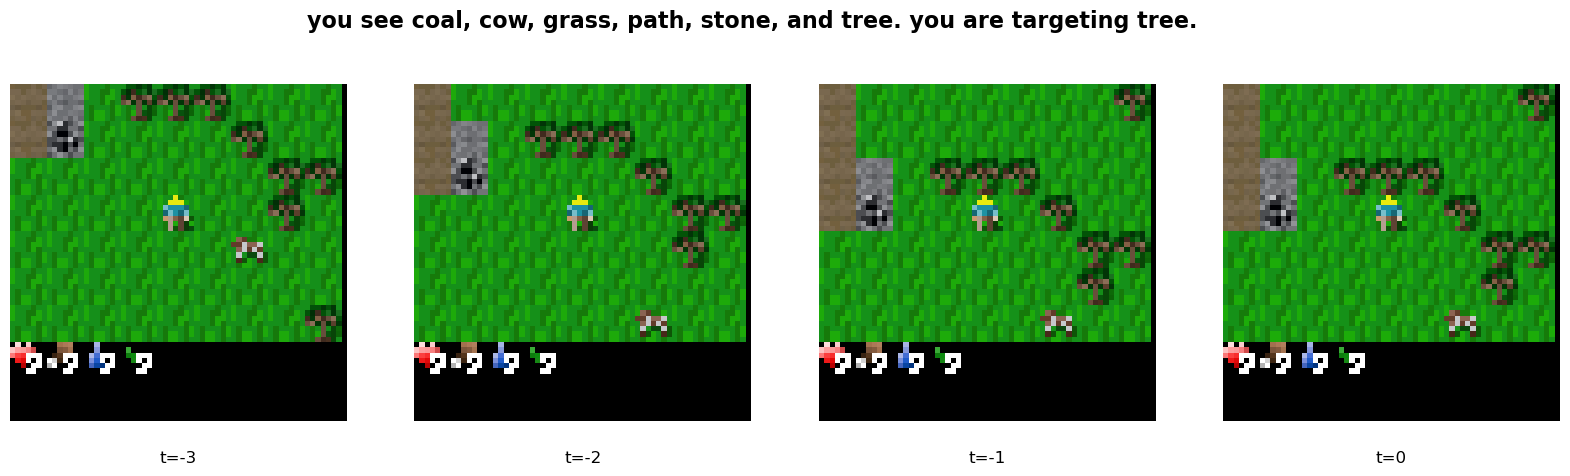

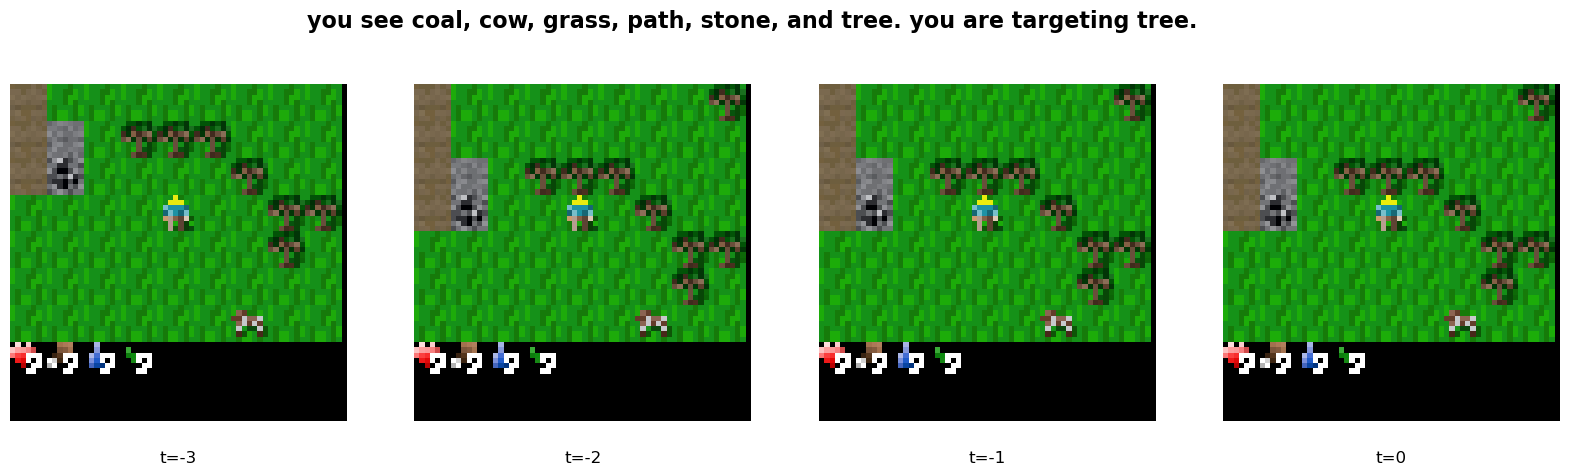

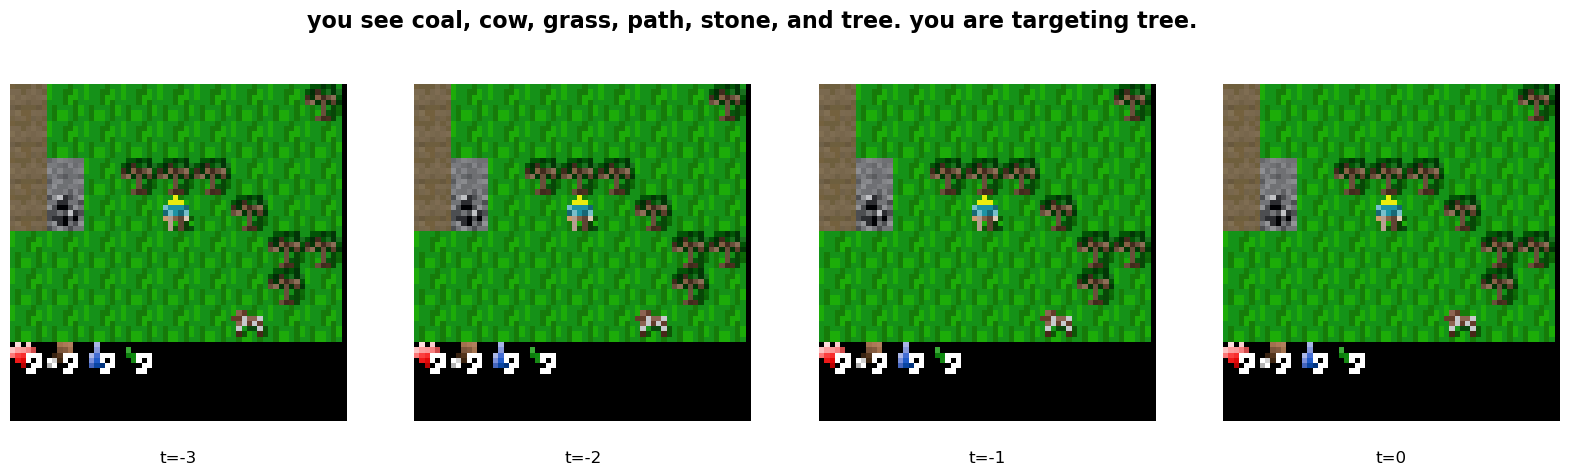

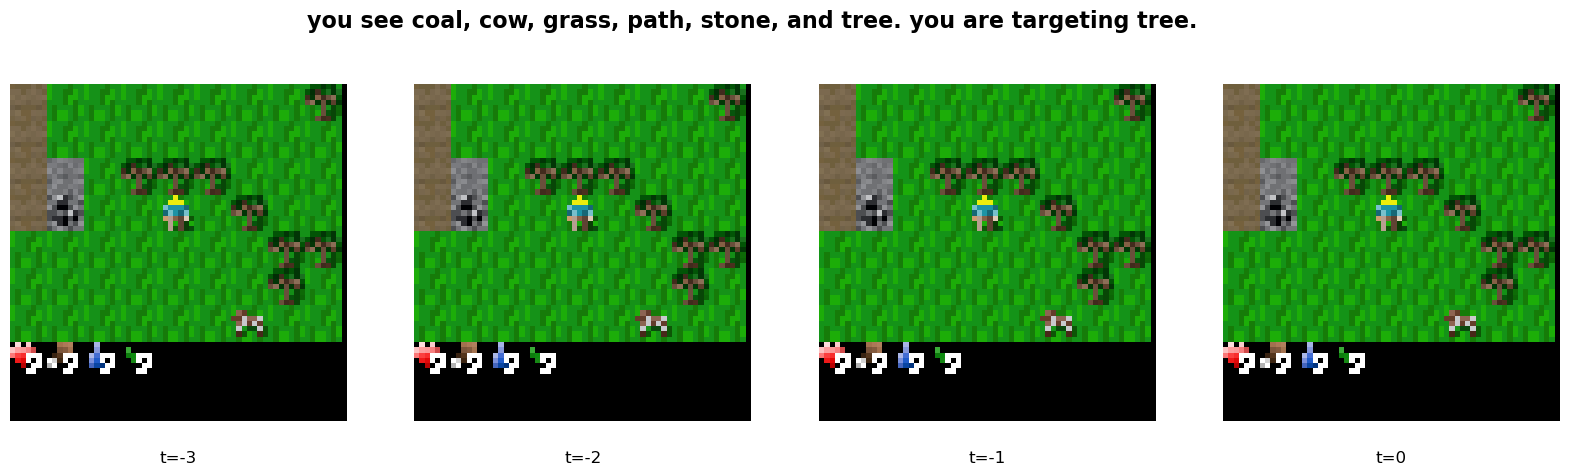

In [9]:
for i in range(10):
    obs, rewards, dones, infos = train_env.step(np.array([3]))
    frame_stack = 4
    fig, axs = plt.subplots(1, frame_stack, figsize=(5 * frame_stack, 5))
    title = infos[0]["text_obs"]
    fig.suptitle(title , fontsize=16, weight="bold" )
    if len(obs['obs'].shape) == 4:
        obs['obs'] = obs['obs'].squeeze()
    for i in range(frame_stack):
        frame = obs['obs'][:,:,i*3:(i+1)*3]
        axs[i].imshow(frame)
        axs[i].axis('off')
        axs[i].set_title(f't={i - frame_stack + 1}', y=-0.15)
    plt.show()